# MovieLens Recommendation System

In the age of streaming, it can be overwhelming trying to find the next show to binge on with thousands of titles available at our fingertips. Recommender systems help guide our search by filtering all this information and returning a list of titles according to our preferences. 

There are 2 types of information filtering are:
1. Content Filtering
2. Collaborative Filtering (CF)

Today's recommender systems implement both methods, making predictions on a user's preferences based on the item's attributes and common preferences among other users.

# Objective
Create a hybridized recommender system that uses content filtering and CF to dynamically recommend titles based on a user's preferences.

# 1. Imports

In [1]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing, feature engineering, and similarity
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# string matching
from fuzzywuzzy import process

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# 2. Load Data
Dataset: https://grouplens.org/datasets/movielens/

In [2]:
movies = pd.read_csv('/Users/kevintie/Desktop/data_projects/projects/movie_rec_project/data/ml-latest-small/movies.csv')
ratings = pd.read_csv('/Users/kevintie/Desktop/data_projects/projects/movie_rec_project/data/ml-latest-small/ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


From the data, the key features I will explore further are: rating (collaborate filtering) and genre (content-based filtering).

# 3. Data Preprocessing

Use collaborative filtering (CF) to recommend titles to users based on similar user preferences. First, transform data into a user-item matrix (utility matrix) where rows represent users and columns represent titles. Each cell in the matrix contains a rating a user gave to a specific movie, which can be used to map different users and titles together.

First, we need to create a utility matrix $X$ and 4 mapper dictionaries to correspond to each user and movie Id:
1. user_mapper: map user Id to user index
2. movie_mapper: map movie Id to movie index
3. user_inv_mapper: map user index to user Id
4. movie_inv_mapper: map movie index to movie Id

In [5]:
def create_X(df):
    '''

    FUNCTION: generate a sparse matrix from the ratings dataframe

    ARGS:  
    df - ratings dataframe containing movie Id, user Id, and rating columns

    RETURN:
    X - utility matrix with 4 mapper dictionaries

    '''
    # store unique user and movie ids into variables
    n_user_id = df['userId'].nunique()
    n_movie_id = df['movieId'].nunique()

    # create mapper dictionaries to label our matrix
    user_mapper = dict(zip(np.unique(df['userId']), list(range(n_user_id))))
    user_inv_mapper = dict(zip(list(range(n_user_id)), np.unique(df['userId'])))

    movie_mapper = dict(zip(np.unique(df['movieId']), list(range(n_movie_id))))
    movie_inv_mapper = dict(zip(list(range(n_movie_id)), np.unique(df['movieId'])))

    # label mappers for data retrieval
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [movie_mapper[i] for i in df['movieId']]

    # create matrix X
    X = csr_matrix((df['rating'], (user_index, item_index)), shape=(n_user_id, n_movie_id))

    # return the created matrix with 4 mapper dictionaries
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [6]:
# apply function to create matrix X and the 4 mapper dictionaries
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [7]:
# overview of matrix X
X.shape

(610, 9724)

### Evaluating Sparsity

We must now calculate the sparsity of our utility matrix in order to determine whether CF is viable based on our ratings data. For example, if the matrix is too sparse, we don't have enough data for our recommender system to work using CF, and instead, should opt for content filtering.

To calculate sparsity, we divide the number non-empty elements (nnz) by the total number of elements in the matrix.

In [8]:
# calculate matrix sparsity
n_total = X.shape[0] * X.shape[1]
# nnz = number of ratings in the ratings dataframe
nnz = X.nnz
sparsity = nnz / n_total

print(f'Matrix sparsity: {sparsity * 100:.2f}%')

Matrix sparsity: 1.70%


In order for CF to be viable, matrix sparsity typically needs to be above 0.5%. Since our sparsity is 1.7%, CF should work well with our current utility matrix. Next, we should check our dataset for any users and movies with few interactions. This is so we can address what's known as the **cold start problem**, which hinders a recommender system using CF to make proper recommendations due to insufficient data. 

In [9]:
# set number ratings per user
ratings_per_user = X.getnnz(axis=1)

# check most and least active users
most_active_user = ratings_per_user.max()
least_active_user = ratings_per_user.min()

print(f'Most active user rated {most_active_user} movies')
print(f'Least active user rated {least_active_user} movies')

Most active user rated 2698 movies
Least active user rated 20 movies


In [10]:
# set number ratings per movie
ratings_per_movie = X.getnnz(axis=0)

# check most and least rated movies
most_rated_movie = ratings_per_movie.max()
least_rated_movie = ratings_per_movie.min()

print(f'Most rated movie has {most_rated_movie} ratings')
print(f'Least rated movie has {least_rated_movie} ratings')

Most rated movie has 329 ratings
Least rated movie has 1 ratings


### Visualize user and movie interactions

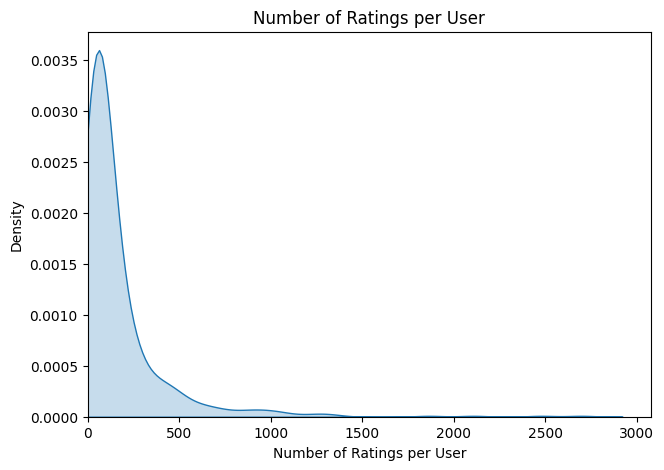

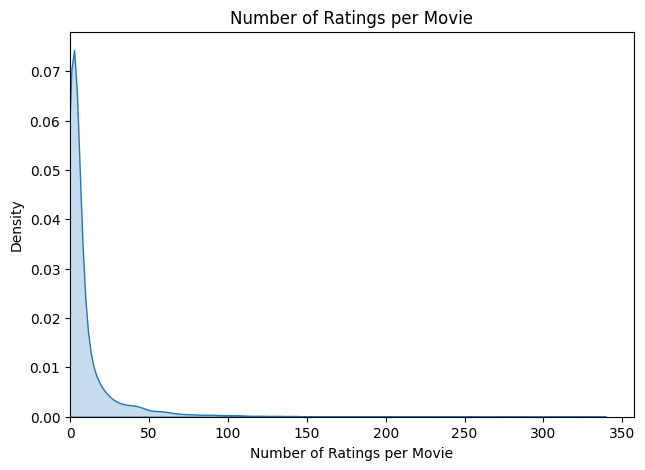

In [11]:
# create user interaction kde subplot 1
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(ratings_per_user, shade=True)

# format subplot 1
plt.xlim(0)
plt.xlabel('Number of Ratings per User')
plt.ylabel('Density')
plt.title('Number of Ratings per User')

# create movie interaction kde subplot 2
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 2)
sns.kdeplot(ratings_per_movie, shade=True)

# format subplot 2
plt.xlim(0)
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Density')
plt.title('Number of Ratings per Movie')

plt.show()

Most users rated less than 100 movies and most movies received less than 50 ratings.

# 5. Make Item to Item Recommendations based on $k$-Nearest Neighbors

To make our recommender system actionable, the k-Nearest Neighbors (kNN) model to arrange similar titles based on their cosine similarity scores in the dataset. Cosine similarity is a popular metric used in Natural Language Processing to measure the similarity between context words. Here, we'll find the $k$ movies that have the most similar user interaction vectors with movie $i$.

In [12]:
# create a function that retrieves k-nearest neighbors of movie i based on cosine similarity scores
def rec_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    '''
    
    FUNCTION: finds k-nearest neighbors of a movie i based on cosine similarity

    ARGS:
    movie_id - movie id of selected movie
    X - utility matrix 
    movie_mapper - mapper for locating movie in utility matrix
    movie_inv_mapper - mapper for locating movie in utility matrix
    k - number of similar movies to retrieve
    metric - distance metric for kNN calculations

    RETURNS:
    List of k similar movie Ids

    '''

    # first, transpose X to set movies as primary axis
    X = X.T
    # empty neighbor id list to locate similar titles
    neighbor_ids = []

    # map movie's id over our utility matrix
    movie_idx = movie_mapper[movie_id]
    movie_vec = X[movie_idx]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1, -1)

    # use k + 1 since KNN output includes movie id of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm='brute', metric=metric)
    kNN.fit(X)

    # find k neighbors
    neighbor = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0, k):
        n = neighbor.item(i)
        neighbor_ids.append(movie_inv_mapper[n])
    neighbor_ids.pop(0)

    return neighbor_ids

Apply get similar movies function to movie id 1.

In [13]:
# first, create a movie titles dictionary, so we can match movie Ids with actual movie titles
movie_titles = dict(zip(movies['movieId'], movies['title']))

# return k neighbor Ids
similar_movies = rec_movies(1, X, movie_mapper, movie_inv_mapper, k=10)

# retrieve input movie's title
movie_title = movie_titles[1]

# convert neighbor Ids to movie titles
rec_titles = []
for i in similar_movies:
    rec_titles.append(movie_titles[i])

print(f'Because you watched {movie_title}: \n{rec_titles}')

Because you watched Toy Story (1995): 
['Toy Story 2 (1999)', 'Jurassic Park (1993)', 'Independence Day (a.k.a. ID4) (1996)', 'Star Wars: Episode IV - A New Hope (1977)', 'Forrest Gump (1994)', 'Lion King, The (1994)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Mission: Impossible (1996)', 'Groundhog Day (1993)']


The recommended movies are similar as they're generally known to be family-friendly movies from the '90s.

# 6. Handling the Cold Start Problem

A recommender system that relies on CF to make recommendations is heavily reliant on user-item matches in the utility matrix. This is a problem because when there is not enough data in the matrix, no recommendation can be made based on a match, creating what's called the **cold start problem**.

To address this issue, we resort to content-based filtering to first gather data to fill our utility matrix with.

### Organize titles by item attributes (i.e. Genre)

In [14]:
# extract genres from movies dataframe for flagging
genres = set(g for genre in movies['genres'] for g in genre)

# flag genres in movies dataframe
for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))

# drop other columns
movie_genres = movies.drop(columns=['movieId', 'title', 'genres'])

movie_genres

,s,|,l,(,a,c,S,h,m,y,...,n,v,H,D,I,X,r,-,e,A
0,1,1,1,0,1,0,0,1,1,1,...,1,1,0,0,0,0,1,0,1,1
1,1,1,1,0,1,0,0,1,0,1,...,1,1,0,0,0,0,1,0,1,1
2,0,1,0,0,1,1,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
3,0,1,0,0,1,1,0,0,1,1,...,1,0,0,1,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,1,1,0,0,1,1,0,0,1,1,...,1,0,0,0,0,0,0,0,1,1
9738,1,1,0,0,1,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,1
9739,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
9740,0,1,0,0,1,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


We have 19 unique genres with 1 category where no genre is listed. Next, we want to group genres by similarity. We can do that by finding the cosine similarity of genres in our movie_genres dataframe.

In [15]:
# pass cosine similarity function through movie_genres dataframe
cosine_sim = cosine_similarity(movie_genres, movie_genres)

print(f'Cosine similarity matrix shape: {cosine_sim.shape} movies')
cosine_sim

Cosine similarity matrix shape: (9742, 9742) movies


array([[1.        , 0.9459053 , 0.62254302, ..., 0.3441236 , 0.61177529,
        0.56195149],
       [0.9459053 , 1.        , 0.5118907 , ..., 0.24253563, 0.48507125,
        0.39605902],
       [0.62254302, 0.5118907 , 1.        , ..., 0.30151134, 0.60302269,
        0.73854895],
       ...,
       [0.3441236 , 0.24253563, 0.30151134, ..., 1.        , 0.33333333,
        0.20412415],
       [0.61177529, 0.48507125, 0.60302269, ..., 0.33333333, 1.        ,
        0.27216553],
       [0.56195149, 0.39605902, 0.73854895, ..., 0.20412415, 0.27216553,
        1.        ]])

The result is a cosine similarity matrix containing values between 0 and 1 where values represent the degree of similarity between movies along the x and y axes.

### Create a movie finder function

In case, we want to get recommendations for a specific movie, a movie finder function would be useful to let a user explore siimlar titles. The problem right now is the titles in our dataset are followed by dates (i.e. 'Toy Story (1995)'), meaning a user would have to type that whole string out just to find similar movies to Toy Story. 

To make the recommender system more user-friendly, fuzzywuzzy is a Python package that uses a string matching algorithm that finds the most similar string inputted.

In [16]:
# create movie finder function
def movie_finder(title):
    titles = movies['title'].to_list()
    match = process.extractOne(title, titles)
    return match[0]

In [17]:
# test movie finder function
search_title = movie_finder('Toy Story')
search_title

'Toy Story (1995)'

Now that we can search for movies, we need a way to match that search to an index in the cosine similarity matrix. To do this, we create another index mapper. 

In [18]:
# create movie index mapper
movie_idx = dict(zip(movies['title'], list(movies.index)))
idx = movie_idx[search_title]
print(f'You searched: {search_title} ID: {idx}')

You searched: Toy Story (1995) ID: 0


With an ID match, we can now recommend similar titles using content-filtering.

In [19]:
# set number of recommendations
n_recommendations = 10

# first, retrieve list of ids and scores from our cosine similarity matrix
cos_sim_score = list(enumerate(cosine_sim[idx]))

# sort this list by most similar
cos_sim_score = sorted(cos_sim_score, key=lambda x: x[1], reverse=True)

# reduce list to cap at n_recommendations
cos_sim_score = cos_sim_score[1:(n_recommendations + 1)]

# extract just the id from the resulting tuples
similar_movies = [i[0] for i in cos_sim_score]

similar_movies

[1357, 1505, 1577, 1706, 2355, 2539, 2809, 3000, 3230, 3336]

Finally, test our recommender by generating 10 similar movies to Toy Story.

In [20]:
print(f'Because you watched: {search_title} \n{movies.title.iloc[similar_movies]}')

Because you watched: Toy Story (1995) 
1357                             Borrowers, The (1997)
1505                        Black Cauldron, The (1985)
1577                     Lord of the Rings, The (1978)
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2539             We're Back! A Dinosaur's Story (1993)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3230                  Atlantis: The Lost Empire (2001)
3336                      Land Before Time, The (1988)
Name: title, dtype: object


These titles all make for great family-friendly movies. We even have a sequel, Toy Story 2, and there are options to view more recently released movies.

To make things more streamlined, we will create a function that allows a user to search for a title and generate $n$ recommendations for that title.

In [21]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    '''
    
    FUNCTION: gets n recommendations via content-filtering based on a title string

    ARGS:
    title string - user inputted title string
    n_recommendations - user set number of similar titles to be recommended

    RETURNS:
    list of similar titles
    
    '''

    # match the user inputted title string with a title in the dataset and extract its id
    title = movie_finder(title_string)
    idx = movie_idx[title]

    # match the id with the cosine similarity matrix
    cos_sim_score = list(enumerate(cosine_sim[idx]))
    cos_sim_score = sorted(cos_sim_score, key=lambda x: x[1], reverse=True)
    cos_sim_score = cos_sim_score[1:(n_recommendations + 1)]

    # list of similar movie ids
    similar_movies = [i[0] for i in cos_sim_score]
    
    print(f'Because you watched {title}: \n{movies.title.iloc[similar_movies]}')

In [22]:
# test content-based recommender
get_content_based_recommendations("Toy Story", n_recommendations=10)

Because you watched Toy Story (1995): 
1357                             Borrowers, The (1997)
1505                        Black Cauldron, The (1985)
1577                     Lord of the Rings, The (1978)
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2539             We're Back! A Dinosaur's Story (1993)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3230                  Atlantis: The Lost Empire (2001)
3336                      Land Before Time, The (1988)
Name: title, dtype: object


# 7. Dimensionality Reduction with Matrix Factorization

We can use Matrix Factorization (MF) to discover any latent features between users and titles, giving a more compact representation of user tastes and item attributes. MF is particularly relevant to sparse matrices because it can enhance the quality of recommendations by imputing missing values in the dataset.

We can reduce our utility matrix into 2 factor matrices:
$$X_{mn} \approx P_{mk} \times Q^{T}_{nk} = \hat{X}$$

\begin{align*}
(\text{n\_users}, \text{k}) \\
(\text{k}, \text{n\_items})
\end{align*}

We can use sklearn's TruncatedSVD to start dimensionality reduction.

In [23]:
# set svd parameters
svd = TruncatedSVD(n_components=20, n_iter=10)

# create item matrix by fitting svd to the transposed utility matrix
Q = svd.fit_transform(X.T)

print(f'Item matrix with {Q.shape[0]} movies and {Q.shape[1]} components')

Item matrix with 9724 movies and 20 components


Test compressed recommender system.

In [24]:
# set Toy Story movie id as 1 because our movie mapper doesn't start from 0
movie_id = 1

# return ids of similar movies
similar_movies = rec_movies(movie_id, Q.T, movie_mapper, movie_inv_mapper, k=10, metric='cosine')

# match id with movie title
movie_title = movie_titles[movie_id]

# recommend movies
print(f'Because you watched {movie_title}: \n{movies.title.iloc[similar_movies]}')

Because you watched Toy Story (1995): 
586     Haunted World of Edward D. Wood Jr., The (1996)
480                            Terminal Velocity (1994)
588                        Great White Hype, The (1996)
1073                               Jerry Maguire (1996)
1270                  I Love You, I Love You Not (1996)
356                        Age of Innocence, The (1993)
1265                               Sliding Doors (1998)
260                                    Quiz Show (1994)
1197                       In the Company of Men (1997)
Name: title, dtype: object


These results are from our compressed kNN movie-factor matrix where we've reduced the number of dimensions to 20 latent features. The recommendations differ compared to the uncompressed version. This can be accounted for by increasing the n_components to an optimal setting that isn't too computationally complex and still returns relevant recommendations. 

### Evaluation Metrics

- RMSE
- Precision @K; Recall @K